# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [331]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier


from imblearn.over_sampling import SMOTE

from scipy.stats import ks_2samp
import warnings
import ast
import re

import umap
import xgboost
from xgboost import XGBClassifier

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Introduction

This post discuss in detail the project "Create a Customer Segmentation Report for Arvato Financial Services", which is one of the Data Scientist's nanodegree capstone options. It is in fact a continuation of a previous project whose solution was posted [here](https://github.com/bvcmartins/dsndProject3). I chose it because of its broad scope which involves a reasonably complex data cleaning procedure, unsupervised learning, analysis of imbalanced data, and prediction using supervised learning tools. In the following I will discuss my solution for it.

### The dataset

Arvato kindly provided us the following four datasets:

1. Azdias: general elements of the german population (891221 entries, 366 features)
2. Customers: same features but containing only customers (191652 entries, 369 features)
3. Mailout_train: training set containing potential customers chosen to receive mail ads. It also contains information if the ad was responded 
4. Mailout_test: testing set for the supervised learning model

On top of that two other files were provided:
1. DIAS Attributes - Values 2017: information about code levels of each attribute
2. DIAS Information Levels - Attributes 2017: high-level information about each attribute

In [4]:
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')

In [5]:
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
azdias.shape

(891221, 366)

Most of the features are ordinal and the numbers only represent a label for ranked value levels. Columns marked as float are actually comprised by ints but were only marked that way because they contain NaN, which is itself a float. The latest pandas version allows us to use the type Int64 which supports a integer NaN.

In [8]:
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

There are also 6 features of type object. These are categorical variables, except for EINGEFUEGT_AM, which is datetime.

In [9]:
azdias.dtypes[azdias.dtypes=='object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

Most of the features contained NaNs. They were distributed in blocks following the clustered structured of the features.

In [373]:
azdias.isnull().values.sum() / (azdias.shape[0]*azdias.shape[1])

0.09517765924690441

### Inspecting Customers

In [12]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Customers data has three extra columns.

In [13]:
customers.shape

(191652, 369)

These are CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP

In [14]:
extra_cols = list(set(customers.columns.values).difference(set(azdias.columns.values)))
extra_cols

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

Two of them are objects and the other is of type int.

In [15]:
customers.dtypes[extra_cols]

CUSTOMER_GROUP     object
ONLINE_PURCHASE     int64
PRODUCT_GROUP      object
dtype: object

The customers dataframe is also full of NaNs.

In [16]:
customers.isnull().sum().values

array([     0,      0,  46596,  46596, 179886, 186552, 190377, 191416,
        51842,  49927,  52110,  46596,  46596,  49927,  46596,  50476,
        49959,  50428,  50428,  50428,   3213,   3213,   3213,   3213,
         3213,   3213,   3213,   3213,      0,      0,      0,      0,
            0,      0,      0,      0,  47697,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,  47697,      0,      0,      0,  47697,  47697,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,  47697,      0,      0,      0,
        49927,  49927,  46596,  49959,  85283,      0,      0,      0,
            0,      0,      0,      0,  49927,  49927,  49927,      0,
      

File DIAS Attributes - Values 2017 contains a description of the encoding for most of the features. For most of them attributes [-1,0] indicate missing or unknown features. These codes were substituted by NaN.

In [17]:
dias_attr = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attr.drop('Unnamed: 0', axis=1, inplace=True)
dias_attr

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [18]:
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
dias_info.drop('Unnamed: 0', axis=1, inplace=True)
dias_info.replace({'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24':'D19_GESAMT_ANZ_12-24',
                  'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24':'D19_BANKEN_ ANZ_12-24',
                 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24':'D19_TELKO_ ANZ_12-24',
                 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24':'D19_VERSI_ ANZ_12-24',
                 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24':'D19_VERSAND_ ANZ_12-24'},inplace=True)
dias_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


Note that features 'EINWOHNER', 'PLZ', 'GKZ', 'PLZ8', which are described in this file are not in azdias or customers.

## Data Cleaning

#### Pre-cleaning

First we defined a pre-clean function to perform a variety of preparation steps. It converts all numeric features to Int64, which supports integer NaNs. It also converts codes X and XX, which are not described in DIAS, to NaNs. 

In [19]:
def pre_clean(df):
    list_numeric = df.dtypes[(df.dtypes=='float64') | (df.dtypes=='int64') ].index.values.tolist()
    df[list_numeric] = df[list_numeric].astype('Int64')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':0, 'O':1}).astype("Int64")
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace({0:np.nan}).astype('Int64')
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace({0:np.nan}).astype('Int64')
    return df.drop('EINGEFUEGT_AM', axis=1)

In [20]:
azdias = pre_clean(azdias)

#### Map values

Next, the missing values [-1,0] for each features are extracted from DIAS and the values are converted in azdias.

In [21]:
def map_values(x, dict_missing):
    try:
        return dict_missing[x]
    except:
        return x
    
def missing_values(df):
    missing_df = dias_attr.query('Meaning=="unknown"')[['Attribute','Value']].dropna().set_index('Attribute')
    missing_df = missing_df['Value'].astype('str').str.split(',',expand=True).T
    missing_df = missing_df.applymap(lambda x: int(x) if x!=None else -100)

    for i in missing_df.columns.values:
        for j in [0,1]:
            dict_missing = {missing_df.loc[j,i]:np.nan}
            try:
                df[i] = df[i].map(lambda x: map_values(x, dict_missing)).astype('Int64')
            except:
                pass

    return df

In [22]:
%%time
azdias = missing_values(azdias)

CPU times: user 3min 35s, sys: 1e+03 ms, total: 3min 36s
Wall time: 3min 35s


#### Assess missing data per feature

Features with more than 445k entries missing, which is half the total size of azdias, were dropped. As shown below, 9 features satisfied this condition.

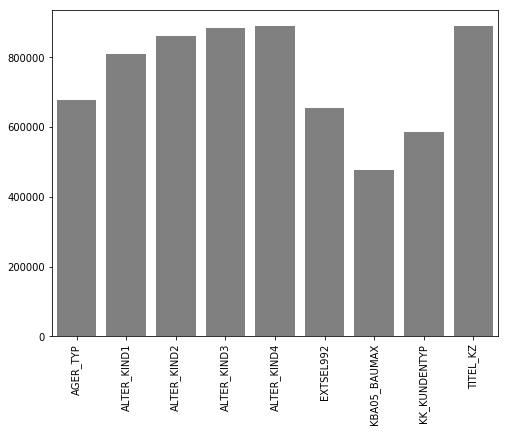

In [23]:
null_df = azdias.isnull().sum()
null_df = null_df[null_df > 445E3]
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(null_df.index, null_df.values, color='gray')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

The dropped values correspond only to 18% of all missin values.

In [24]:
azdias[null_df.index].isnull().sum().sum() / azdias.isnull().sum().sum()

0.18222273002095582

In [25]:
feature_drop_list = pd.Series(azdias.isnull().sum()).where(lambda x:  x > 445E3).dropna().index.tolist()
feature_drop_list

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [26]:
def drop_features(df, feature_drop_list):
    return df.drop(feature_drop_list, axis=1)

In [27]:
azdias = drop_features(azdias, feature_drop_list)

### Assess missing data per row

After dealing with missing data per column, we turn our attention to missing data per row. Some rows have too many missing values and imputing them might not be the best option. In general, for these cases, too mush information was lost and imputing will only reproduce the average user.

In [28]:
missing_rows = azdias.isnull().sum(axis=1)

For this dataset the missing values are divided in about 4 clusters. The fourth one has a lower cuttoff around 160 missing values. We selected all entries with more missing value than the cuttoff for further analysis. 

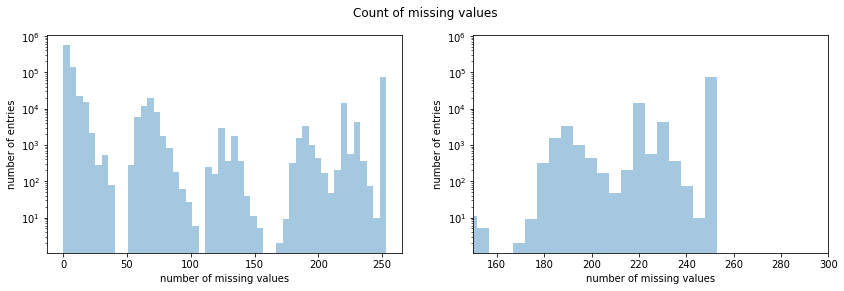

In [322]:
fig,ax = plt.subplots(figsize=(14,4), ncols=2, nrows=1)
sns.distplot(missing_rows, kde=False, ax=ax[0])
ax[0].set_xlabel('number of missing values')
ax[0].set_ylabel('number of entries')
ax[0].set_yscale('log')
sns.distplot(missing_rows, kde=False, ax=ax[1])
ax[1].set_xlim([150,300])
#ax[1].set_ylim([0,10000])
ax[1].set_yscale('log')
ax[1].set_xlabel('number of missing values')
ax[1].set_ylabel('number of entries');
plt.suptitle('Count of missing values');

#### Cutoff for missing values is 160

In [30]:
azdias_below = azdias[azdias.isnull().sum(axis=1)<160].copy().reset_index().drop('index', axis=1)
azdias_above = azdias[azdias.isnull().sum(axis=1)>=160].copy().reset_index().drop('index', axis=1)

Next we applied the Kolmogorov-Smirnov test to check if the selected subset is different from the main data body. The null hypothesis was that both groups were identical.

In [323]:
list_numeric = azdias.dtypes[(azdias.dtypes=='int64') | 
                             (azdias.dtypes=='Int64') | 
                             (azdias.dtypes=='float64')].index[1:].tolist()
columns_not_missing = (azdias_above.isnull().sum()==0).index[1:].tolist()
columns_test = set(columns_not_missing).intersection(set(list_numeric))
n_columns_test = len(columns_test)

In [32]:
ks_df = pd.DataFrame(azdias[columns_test].columns, columns=['col'])
  
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_below[columns_test], azdias_above[columns_test], azdias_below[columns_test].columns.values)
ks_df['stats'] = stats
ks_df['pvalues'] = pvalues
ks_df.dropna(axis=0, inplace=True)

In [33]:
ks_df.head()

,col,stats,pvalues
0,RT_KEIN_ANREIZ,1.000000,0.007937
1,CJT_TYP_3,1.000000,0.007937
3,FINANZ_VORSORGER,1.000000,0.007937
4,D19_GESAMT_ANZ_24,0.857143,0.008159
6,ARBEIT,0.833333,0.025974


Because the test involves multiple comparisons, we must apply some form of correction. It we apply the Bonferroni test we conclude that only 8.3 % of the columns differ. By taking that as corresponding to a p-value of 0.083, we failed to reject the null hypothesis and kept the rows.

In [324]:
ks_df[ks_df['pvalues']<0.05/n_columns_test].shape[0] / ks_df.shape[0]

0.08287292817679558

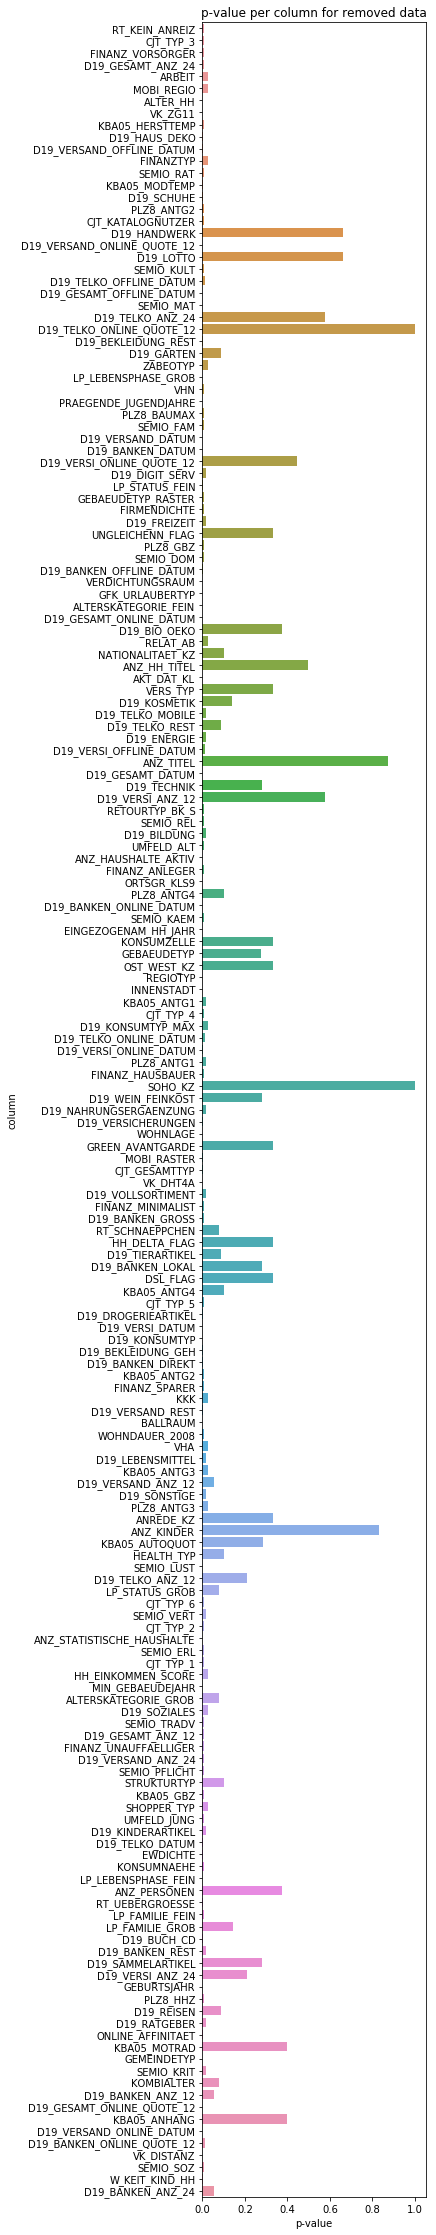

In [369]:
fig,ax = plt.subplots(figsize=(4,40))
sns.barplot(y='col', x='pvalues', data=ks_df, ax=ax)
ax.set_xlabel('p-value')
ax.set_ylabel('column');
ax.set_title('p-value per column for removed data');

In [36]:
def drop_rows(df):
    return df[df.isnull().sum(axis=1)<160].copy().reset_index().drop('index', axis=1)

In [37]:
#azdias2 = drop_rows(azdias.copy())
azdias2 = azdias.copy()

## Data Imputation

For imputation we had to separate numeric from object features. The following functions perform imputation on numeric features using strategy mean and on categorical features using strategy median. It is worthy pointing out here an interesting fact. During the test rounds I tried to use the Iterative Imputer, an experimental method that tries to apply prediction to imputation. I used KNearest Neighbors with 5 neighbors as the prediction method but the prediction results were not match to the more standard mean and median values imputation.

#### Impute ints using median, floats using mean and objects using most frequent value

In [38]:
def impute_numeric(df, strategy):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(df)
    return imputer.transform(df)

def impute_object(df):
    list_mode = df.apply(lambda x: x.mode()[0]).values.tolist()
    list_columns = df.columns.values.tolist()
    dict_mode = {i:j for i,j, in zip(list_columns, list_mode)}
    return df.fillna(value=dict_mode)
    
def impute_calc(df):
    list_numeric = df.dtypes[(df.dtypes=='int64') | 
                             (df.dtypes=='Int64') | 
                             (df.dtypes=='float64')].index[1:].tolist()
    df[list_numeric] = impute_numeric(df[list_numeric].astype('Int64'),'median').astype('int64')
    list_objects = df.dtypes[(df.dtypes=='object')].index.tolist()
    df[list_objects] = impute_object(df[list_objects])
    
    return df

In [39]:
azdias2 = impute_calc(azdias2)

In [40]:
azdias2.isnull().values.any()

False

### Re-encode mixed features



#### PRAEGENDE_JUGENDJAHRE

#### Two new attributes were created 

#### Levels for PRAGENDE_JUGENDJAHRE_intervall  
#### Dictionary pji_dict
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Levels for PRAGENDE_JUGENDJAHRE_trend
#### Dictionary pjt_dict
- 0: mainstream
- 1: avantgarde

In [41]:
def pragende_jugendjahre(df):
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_intervall'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])
    df['PRAEGENDE_JUGENDJAHRE_trend'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])
# drop original attribute from dataset
    return df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [42]:
azdias2 = pragende_jugendjahre(azdias2)

### Mixed-type variable CAMEO_INTL_2015

#### Two new attributes were created

#### Levels for CAMEO_INTL_2015_reichtum
#### Dictionary cir_dict
- 1: Wealthy
- 2: Prosperous
- 3: Comfortable
- 4: Less Affluent
- 5: Poorer

#### Levels for CAMEO_INTL_2015_leben
#### Dictionary cil_dict
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families &  Mature Couples
- 5: Elders In Retirement

In [43]:
def cameo_intl_2015(df):
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df['CAMEO_INTL_2015_reichtum'] = df['CAMEO_INTL_2015'].map(cir_dict).astype('int64')
    df['CAMEO_INTL_2015_leben'] = df['CAMEO_INTL_2015'].map(cil_dict).astype('int64')
    return df.drop('CAMEO_INTL_2015', axis=1)

In [44]:
azdias2 = cameo_intl_2015(azdias2)

### Mixed-type variable LP_LEBENSPHASE_FEIN

#### Three new attributes were created.

#### Levels for LP_LEBENSPHASE_FEIN_alter
#### Dictionary llfa_dict

- 1: young age
- 2: middle age
- 3: retirement age
- 4: advanced age
- 5: higher age

#### Levels for LP_LEBENSPHASE_FEIN_verdiener
#### Dictionary llfv_dict

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

#### Levels for LP_LEBENSPHASE_FEIN_familie
#### Dictionary llff_dict

- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

In [45]:
def lp_lebensphase_fein(df):
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].astype('int64')
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

    # transformation of LP_LEBENSPHASE_FEIN
    df['LP_LEBENSPHASE_FEIN_alter'] = df['LP_LEBENSPHASE_FEIN'].map(llfa_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_verdiener'] = df['LP_LEBENSPHASE_FEIN'].map(llfv_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_familie'] = df['LP_LEBENSPHASE_FEIN'].map(llff_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_FEIN', axis=1)



In [46]:
azdias2 = lp_lebensphase_fein(azdias2)

### Mixed-type variable LP_LEBENSPHASE_GROB

#### Three new attributes were created

#### Levels for LP_LEBENSPHASE_GROB_alter:
#### Dictionary llga_dict  
- 1: young age  
- 2: middle age  
- 3: higher age  

#### Levels for LP_LEBENSPHASE_GROB_verdiener:
#### Dictionary llgv_dict  
- 0: low-income and average earner  
- 1: high-income  

#### Levels for LP_LEBENSPHASE_GROB_familie:
#### Dictionary llgf_dict  
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

In [47]:
def lp_lebensphase_grob(df):
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].astype('int64')
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:0, 11:1, 12:1}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    
    df['LP_LEBENSPHASE_GROB_alter'] = df['LP_LEBENSPHASE_GROB'].map(llga_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_verdiener'] = df['LP_LEBENSPHASE_GROB'].map(llgv_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_familie'] = df['LP_LEBENSPHASE_GROB'].map(llgf_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_GROB', axis=1)

In [48]:
azdias2 = lp_lebensphase_grob(azdias2)

### Mixed-type variable PLZ8_BAUMAX

#### Two new attributes were created

PLZ8_BAUMAX 	most common building-type within the PLZ8 	1 	mainly 1-2 family homes
2038 	NaN 	NaN 	2 	mainly 3-5 family homes
2039 	NaN 	NaN 	3 	mainly 6-10 family homes
2040 	NaN 	NaN 	4 	mainly >10 family homes
2041 	NaN 	NaN 	5 	mainly business building

#### Levels for PLZ8_BAUMAX_geschaft:
#### Dictionary pbg_dict  
- 0: business building  
- 1: residential building 

#### Levels for PLZ8_BAUMAX_nummer:
#### Dictionary pbn_dict  
- 0: mainly 1-2 family homes
- 1: mainly 3-5 family homes
- 2: mainly 6-10 family homes
- 3: mainly >10 family homes

In [49]:
#def plz8_baumax(df):
#    pbg_dict={5:0, 1:1, 2:1, 3:1, 4:1}
#    pbn_dict={1:1, 2:2, 3:3, 4:4, 5:0}
#    
#    df['PLZ8_BAUMAX_geschaft'] = df['PLZ8_BAUMAX'].map(pbg_dict).astype('Int64')
#    df['PLZ8_BAUMAX_nummer'] = df['PLZ8_BAUMAX'].map(pbn_dict).astype('Int64')

    # drop original attribute from dataset
#    return df.drop('PLZ8_BAUMAX', axis=1)

#azdias_below2 = plz8_baumax(azdias_below2)

## One-hot encoding

In [50]:
def make_lists(df):
    list_all = df.columns.tolist()[1:]
    list_onehot = dias_info['Attribute'].str.extract(r'([0-9A-Z_]*TYP)', expand=True).\
    dropna().\
    stack().\
    values.\
    tolist()
    list_onehot = list(set(list_onehot).intersection(set(list_all)))
    list_binary = [column for column in df.columns.tolist() if df[column].value_counts().shape[0]==2]
    #list_onehot = set(list_onehot).difference(set(list_binary))
    list_scale = list(set(list_all).difference(set(list_binary)).difference(set(list_onehot)))
    
    # specific corrections
    list_scale.remove('D19_LETZTER_KAUF_BRANCHE')
    list_onehot.append('D19_LETZTER_KAUF_BRANCHE')
    list_scale.remove('CAMEO_DEUG_2015')
    list_onehot.append('CAMEO_DEUG_2015')
    list_scale.remove('CAMEO_DEU_2015')
    list_onehot.append('CAMEO_DEU_2015')
    
    return list_onehot, list_binary, list_scale

In [51]:
list_onehot, list_binary, list_scale = make_lists(azdias2)

In [327]:
list_onehot

['ZABEOTYP',
 'VERS_TYP',
 'REGIOTYP',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'SHOPPER_TYP',
 'FINANZTYP',
 'D19_KONSUMTYP',
 'HEALTH_TYP',
 'GEBAEUDETYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [52]:
azdias2.isnull().values.any()

False

In [53]:
def adjust_types(df):
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int')
    return df.drop('LNR', axis=1)

In [54]:
azdias2 = adjust_types(azdias2)

In [55]:
onehot = OneHotEncoder()
onehot.fit(azdias2[list_onehot])
df_onehot = pd.DataFrame(data = onehot.transform(azdias2[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())

In [56]:
df_onehot.shape, azdias2.shape

((791314, 148), (791314, 361))

In [57]:
azdias3 = pd.concat([azdias2.drop(list_onehot, axis=1), df_onehot], axis=1)

In [58]:
azdias3.shape

(791314, 496)

### Scaling

In [59]:
scaler = StandardScaler()
azdias3[list_scale] = scaler.fit_transform(azdias3[list_scale])

In [60]:
azdias3.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [333]:
def pca_components(df, minRange, maxRange):
    evr = {}
    for i in range(minRange, maxRange):
        pca_model = PCA(n_components=i)
        X_pca = pca_model.fit_transform(df)
        evr[i] = pca_model.explained_variance_ratio_.sum()
    return evr

def generate_pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    #for i in range(num_comp):

#        ax.annotate(r"%s" % ((str(vals[i]*100)[:4])), 
#                    (idx[i], vals[i]*10), 
#                    va="bottom", 
#                    ha="center", 
#                    fontsize=8)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")

In [63]:
evr = pca_components(azdias3, 100, 150)

We chose 124 components because it is the smallest number of components for 80% explained variance ratio.

In [64]:
n_dim = [key for key, value in evr.items() if value>=0.8][0]
n_dim

124

In [70]:
n_dim = 124
list_pca = azdias3.columns.values.tolist()
pca_model, var_pca, X_pca = generate_pca(azdias3, n_dim)

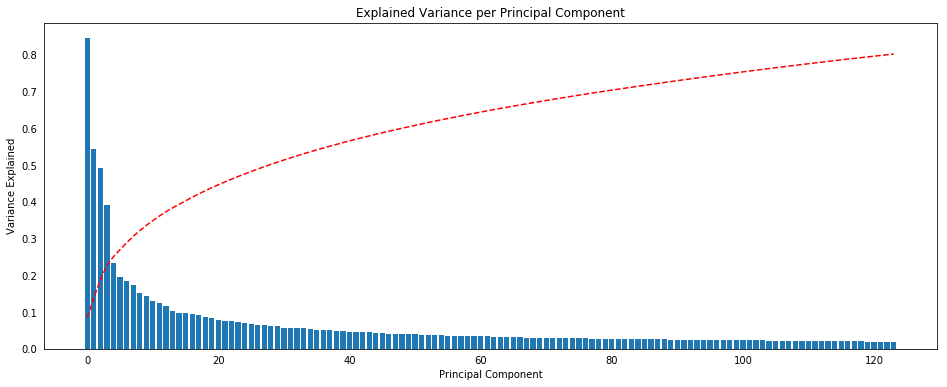

In [334]:
scree_plot_pca(pca_model)

### K-Means

Our first attempt with clustering was with k-means.

In [122]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(5,25):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [196]:
k_step, k_dist, k_score = scree_plot_kmeans(X_pca)

clusters: 5, score: -187592965.75542957, dist: 15.199058304082552
clusters: 6, score: -184468795.7166366, dist: 15.03266858558579
clusters: 7, score: -182110821.14129853, dist: 14.950952840044861
clusters: 8, score: -180017646.1672382, dist: 14.965641940195495
clusters: 9, score: -178266300.60436413, dist: 14.905244912787683
clusters: 10, score: -176852522.41285926, dist: 14.830474446855414
clusters: 11, score: -175468344.8294559, dist: 14.903407843924198
clusters: 12, score: -174240114.33713588, dist: 14.880331457365259
clusters: 13, score: -173067684.27254775, dist: 15.036538680142225
clusters: 14, score: -172052919.30034006, dist: 14.947560958344761
clusters: 15, score: -171546754.2633771, dist: 14.695177055115265
clusters: 16, score: -170353701.0993238, dist: 14.860894986243022
clusters: 17, score: -169655722.39510003, dist: 14.809044311679143
clusters: 18, score: -169355045.4467362, dist: 14.633522737466144
clusters: 19, score: -168133888.80002192, dist: 14.739927635552668
cluster

Text(0.5, 0.98, 'Scree plot for K-Means')

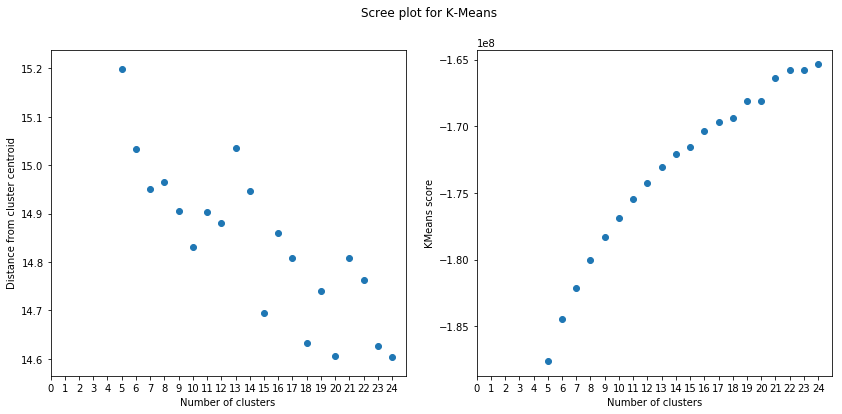

In [199]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(k_step, k_dist)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Distance from cluster centroid')
ax[0].set_xticks(np.arange(0, 25, 1.0));
ax[1].scatter(k_step, k_score)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('KMeans score')
ax[1].set_xticks(np.arange(0, 25, 1.0));
plt.suptitle('Scree plot for K-Means')

In [365]:
def calc_clusters(method):
    model= method.fit(X_pca)
    df = pd.DataFrame(X_pca)
    df['clusters'] = model.labels_
    
    return df, model

def plot_clusters(df, n_clusters, hue):
    palette = sns.color_palette("Set2", n_clusters).as_hex()

    fig, axis = plt.subplots(1, figsize=(12,10))

    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue=hue, palette=palette)
    axis.set_xlim([-15,25])
    plt.title('Cluster projection of first two PCA axes')

def plot_pops(df):
    df_ = df['clusters'].value_counts(normalize=True).reset_index()
    sns.barplot(x = 'index', y = 'clusters', data=df_, color='gray')    
    plt.title('Relative cluster populations')
    

In [126]:
n_clusters = 20
kmeans_df, kmeans =  calc_clusters(KMeans(n_clusters = n_clusters, random_state=34))

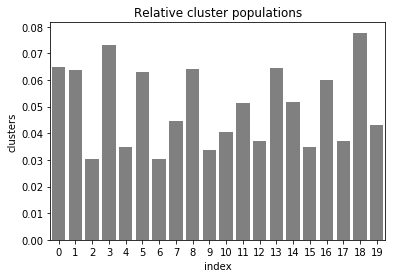

In [338]:
plot_pops(kmeans_df)

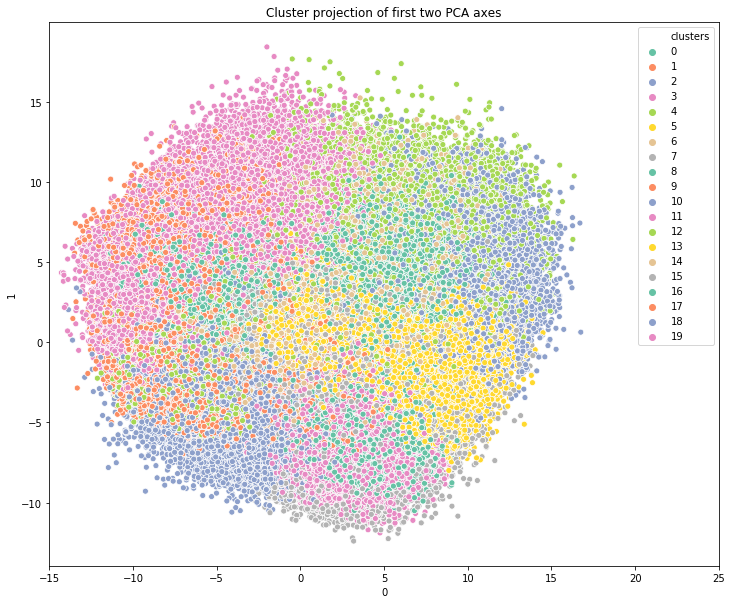

In [366]:
plot_clusters(kmeans_df, n_clusters, hue='clusters')

### Apply data processing to customers

In [390]:
def clean_customer(df):
    df_extra = df[['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']]
    return df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1), df_extra

def pipeline(df):
    df = pre_clean(df)
    df = missing_values(df)
    df = drop_features(df, feature_drop_list)
    #df = drop_rows(df)
    df = impute_calc(df)
    df = pragende_jugendjahre(df)
    df = cameo_intl_2015(df)
    df = lp_lebensphase_fein(df)
    df = lp_lebensphase_grob(df)
    df = adjust_types(df)
    #df, df_extra = clean_customer(df)
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
    df[list_scale] = scaler.transform(df[list_scale])
    X_pca = pca_model.transform(df[list_pca])
    kmeans_pipe = pd.DataFrame(X_pca)
    kmeans_pipe['clusters'] = kmeans.predict(X_pca)
    
    return df, kmeans_pipe

In [130]:
customers_mod = customers.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)

In [132]:
df_customers, kmeans_pipe = pipeline(customers_mod.copy())

In [349]:
def plot_pops_comp(df1,df2):
    df_1 = df1['clusters'].value_counts(normalize=True).reset_index()
    df_2 = df2['clusters'].value_counts(normalize=True).reset_index()
    sns.barplot(x = 'index', y = 'clusters', data=df_1, color='black', alpha=0.2)    
    sns.barplot(x = 'index', y = 'clusters', data=df_2, color='red', alpha=0.4)
    plt.title('Relative cluster populations')

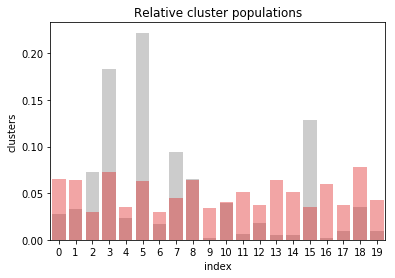

In [350]:
plot_pops_comp(kmeans_pipe, kmeans_df)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [134]:
mailout_train = pd.read_csv('data/mailout_train.csv')

In [135]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [136]:
mailout_train.shape

(42962, 367)

In [137]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [138]:
df_mailout_train, kmeans_train = pipeline(mailout_train.copy())

In [139]:
df_mailout_train.shape, kmeans_train.shape

((35096, 497), (35096, 125))

In [140]:
kmeans_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,clusters
0,-5.267240,-4.682783,2.555490,6.882862,-0.269018,3.552564,-1.840115,-0.246669,-0.694496,-0.222268,1.133857,-0.372996,0.021991,-0.939394,-1.938789,1.522607,1.035946,0.681141,-2.322233,-2.142787,-0.880772,0.102634,0.343932,0.371459,0.383527,-1.485521,-1.269155,-0.744483,1.246895,2.389553,2.019179,0.086369,-1.570159,1.880131,-2.979970,1.864624,-1.396816,-2.092155,1.298445,0.491987,-0.348482,0.168164,-0.540193,-1.000043,0.578146,0.466354,0.379087,0.769923,0.448181,0.795588,1.264439,0.243596,1.134793,-1.659213,-0.684358,-0.421550,-0.706934,0.721466,-0.315394,0.290423,-0.682997,1.032932,-0.754519,-0.584029,0.368932,-1.316099,-1.465549,0.719255,-0.288713,0.746847,-0.522582,0.051953,-0.227260,-1.137792,-0.840553,1.483048,0.139103,0.453012,0.449958,-0.535770,0.378830,0.280201,-0.076010,-0.208462,0.666089,-0.410020,0.676507,-0.065595,-0.585011,0.514072,-2.052977,0.355140,-1.148980,0.346481,-0.854709,0.345943,0.402757,0.088197,0.078346,-0.540782,0.207282,0.245568,-0.330697,-1.024395,-0.228958,1.117869,0.872839,-0.308057,1.774220,-2.234345,0.588732,0.219617,-0.619220,-0.285362,-0.654709,-0.694645,-0.643305,-0.566846,1.134675,0.860750,-0.108446,1.147677,1.557588,-0.866240,10
1,9.689803,0.165826,-3.357597,1.243669,-2.281934,2.640780,-2.913668,-1.947833,1.150220,-0.378506,0.758958,-0.093433,1.820193,0.722079,4.230173,0.507641,0.886074,-1.031550,-0.874236,-1.157902,-1.100280,3.385096,0.569802,6.842967,4.451868,-1.531274,2.608049,1.096946,2.944666,-1.926669,1.549908,-1.697545,1.482100,0.268960,2.444343,-2.203536,1.812009,-2.226375,-0.447375,-2.763841,-4.545826,0.719501,0.630603,-0.624413,-1.760905,-0.196711,0.366951,1.023393,0.497917,0.746044,-1.482139,0.768589,-1.006855,-1.406086,0.053610,-1.197077,0.850067,1.699925,1.514675,-2.084293,1.065843,1.291828,-0.368584,-0.057707,-1.328068,-1.444634,0.865839,0.612552,0.845525,-0.431570,-0.027407,1.172915,-0.213319,-1.180144,-0.952498,-0.744396,-1.366902,0.922859,1.744639,0.661830,0.039446,-1.235471,-0.346330,1.917477,2.117949,-3.978214,1.683614,-0.423916,1.922771,1.285496,-0.188113,0.477874,-2.020045,-0.492601,0.482041,-3.343884,3.267129,-0.268690,2.212993,0.461828,0.694184,0.498268,-0.081878,2.752088,0.833112,-2.566487,0.407762,1.940244,0.408154,-0.617327,0.402500,-0.979934,0.621910,1.084676,-0.258477,-2.454843,0.038964,-1.133219,0.225290,-0.413361,-0.017149,-0.233533,0.998433,1.500529,5
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104935,3.849278,-1.093625,-1.470362,4.312304,-0.449021,1.332211,-1.292222,-2.523775,0.392229,-2.082771,-1.567530,0.303031,-2.772623,1.762764,0.883117,1.000380,-1.865906,0.815311,0.721804,-1.103714,-0.709893,0.434727,0.243259,-1.491161,-1.470136,2.808309,0.131904,0.194118,-2.037014,2.036869,0.550398,-1.576478,0.428547,0.379799,-0.938465,1.016534,0.268196,1.054304,0.231467,-0.931043,-0.335132,1.610634,2.918896,-2.033996,1.387102,-1.551654,-1.646623,-0.014775,-0.184402,0.545100,-1.580199,1.260434,-1.701787,-1.324277,-0.050870,0.373607,-0.542055,-0.108516,2.163221,-1.571681,-0.466796,1.902979,-2.047102,-1.226738,0.766491,-2.015684,1.112935,-0.217036,1.290087,-0.298347,0.789076,-0.021130,0.447585,-0.740195,-0.976694,1.098759,0.446408,-0.269481,0.945031,1.350800,-0.377393,-0.919922,0.202898,1.060738,0.396327,-0.185108,-0.517428,1.036985,0.109938,0.235202,-1.506698,-0.374339,1.479307,-1.971693,-0.268233,0.320518,1.043735,0.415611,-0.942635,-0.789326,0.707239,1.018174,0.462806,0.292062,2.018184,-1.326788,0.119635,1.074916,-1.292720,0.941560,-0.190557,-1.717493,-0.069425,-1.146924,0.322238,1.085516,0.080519,-0.427012,3
3,1.733053,-9.345069,10.415830,3.284154,-0.320023,-4.100706,-0.9014

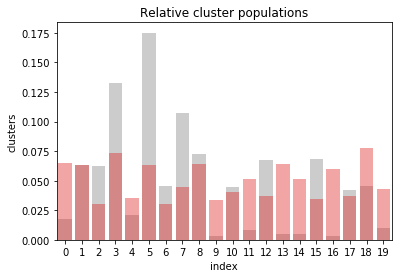

In [353]:
df_mailout_train['clusters'] = kmeans_train['clusters']
df_0 = df_mailout_train.query('RESPONSE==0')
plot_pops_comp(df_0, kmeans_df)

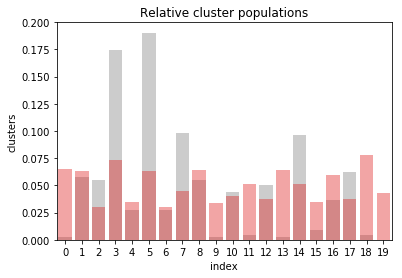

In [354]:
df_1 = df_mailout_train.query('RESPONSE==1')
plot_pops_comp(df_1, kmeans_df)

In [143]:
kmeans_train['RESPONSE'] = df_mailout_train['RESPONSE']

In [ ]:
def plot_clusters(df, n_clusters):
    palette = sns.color_palette("Set2", n_clusters).as_hex()
    colors = []
    colors.extend([palette[10], palette[9], palette[8], palette[7], palette[6]])

    fig, axis = plt.subplots(1, figsize=(12,10))

    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue='clusters', palette=palette)
    axis.set_xlim([-15,25])


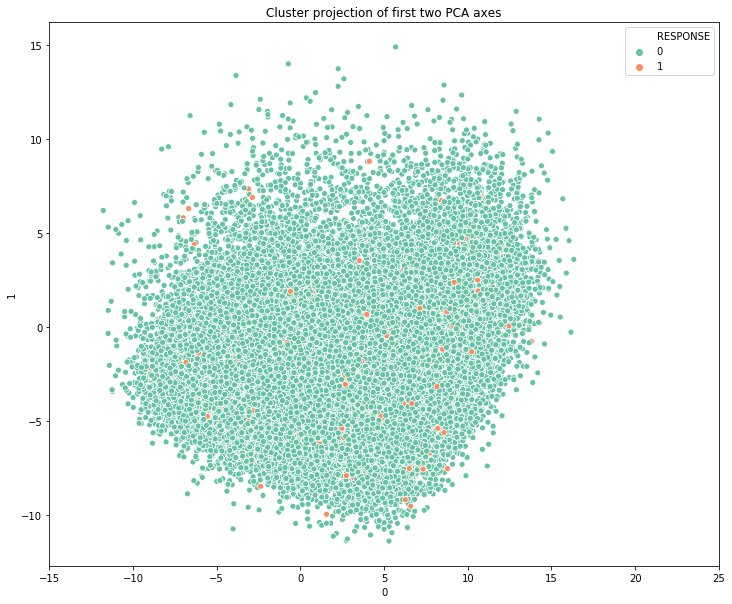

In [367]:
plot_clusters(kmeans_train, 2, hue='RESPONSE')

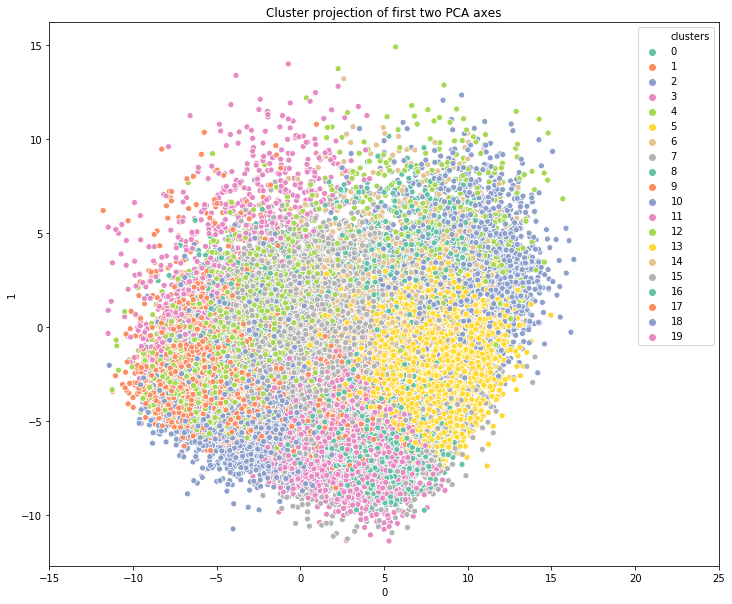

In [368]:
plot_clusters(kmeans_train, 20, hue='clusters')

In [426]:
df_mailout_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

In [427]:
df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_mailout_train.iloc[:,:-1].values))

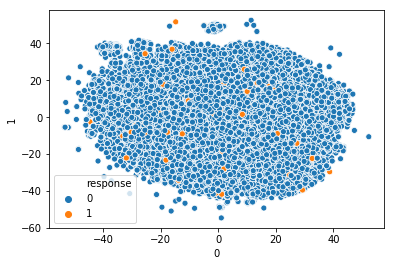

In [429]:
df_tsne['response'] = kmeans_train.RESPONSE
sns.scatterplot(x=0, y=1, data=df_tsne, hue='response')

In [419]:
X_tsne = TSNE(n_components=2).fit_transform(kmeans_train.iloc[:,:-2])

In [424]:
X_tsne2 = pd.DataFrame(X_tsne.copy())
X_tsne2['response'] = kmeans_train.RESPONSE

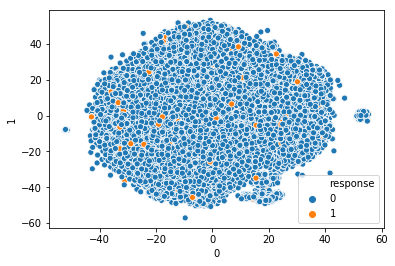

In [425]:
 sns.scatterplot(x=0, y=1, data=X_tsne2, hue='response')

In [147]:
dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)
kmeans_train_extended.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,-5.267240,-4.682783,2.555490,6.882862,-0.269018,3.552564,-1.840115,-0.246669,-0.694496,-0.222268,1.133857,-0.372996,0.021991,-0.939394,-1.938789,1.522607,1.035946,0.681141,-2.322233,-2.142787,-0.880772,0.102634,0.343932,0.371459,0.383527,-1.485521,-1.269155,-0.744483,1.246895,2.389553,2.019179,0.086369,-1.570159,1.880131,-2.979970,1.864624,-1.396816,-2.092155,1.298445,0.491987,-0.348482,0.168164,-0.540193,-1.000043,0.578146,0.466354,0.379087,0.769923,0.448181,0.795588,1.264439,0.243596,1.134793,-1.659213,-0.684358,-0.421550,-0.706934,0.721466,-0.315394,0.290423,-0.682997,1.032932,-0.754519,-0.584029,0.368932,-1.316099,-1.465549,0.719255,-0.288713,0.746847,-0.522582,0.051953,-0.227260,-1.137792,-0.840553,1.483048,0.139103,0.453012,0.449958,-0.535770,0.378830,0.280201,-0.076010,-0.208462,0.666089,-0.410020,0.676507,-0.065595,-0.585011,0.514072,-2.052977,0.355140,-1.148980,0.346481,-0.854709,0.345943,0.402757,0.088197,0.078346,-0.540782,0.207282,0.245568,-0.330697,-1.024395,-0.228958,1.117869,0.872839,-0.308057,1.774220,-2.234345,0.588732,0.219617,-0.619220,-0.285362,-0.654709,-0.694645,-0.643305,-0.566846,1.134675,0.860750,-0.108446,1.147677,1.557588,-0.866240,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,9.689803,0.165826,-3.357597,1.243669,-2.281934,2.640780,-2.913668,-1.947833,1.150220,-0.378506,0.758958,-0.093433,1.820193,0.722079,4.230173,0.507641,0.886074,-1.031550,-0.874236,-1.157902,-1.100280,3.385096,0.569802,6.842967,4.451868,-1.531274,2.608049,1.096946,2.944666,-1.926669,1.549908,-1.697545,1.482100,0.268960,2.444343,-2.203536,1.812009,-2.226375,-0.447375,-2.763841,-4.545826,0.719501,0.630603,-0.624413,-1.760905,-0.196711,0.366951,1.023393,0.497917,0.746044,-1.482139,0.768589,-1.006855,-1.406086,0.053610,-1.197077,0.850067,1.699925,1.514675,-2.084293,1.065843,1.291828,-0.368584,-0.057707,-1.328068,-1.444634,0.865839,0.612552,0.845525,-0.431570,-0.027407,1.172915,-0.213319,-1.180144,-0.952498,-0.744396,-1.366902,0.922859,1.744639,0.661830,0.039446,-1.235471,-0.346330,1.917477,2.117949,-3.978214,1.683614,-0.423916,1.922771,1.285496,-0.188113,0.477874,-2.020045,-0.492601,0.482041,-3.343884,3.267129,-0.268690,2.212993,0.461828,0.694184,0.498268,-0.081878,2.752088,0.833112,-2.566487,0.407762,1.940244,0.408154,-0.617327,0.402500,-0.979934,0.621910,1.084676,-0.258477,-2.454843,0.038964,-1.133219,0.225290,-0.413361,-0.017149,-0.233533,0.998433,1.500529,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104935,3.849278,-1.093625,-1.470362,4.312304,-0.449021,1.332211,-1.292222,-2.523775,0.392229,-2.082771,-1.567530,0.303031,-2.772623,1.762764,0.883117,1.000380,-1.865906,0.815311,0.721804,-1.103714,-0.709893,0.434727,0.243259,-1.491161,-1.470136,2.808309,0.131904,0.194118,-2.037014,2.036869,0.550398,-1.576478,0.428547,0.379799,-0.938465,1.016534,0.268196,1.054304,0.231467,-0.931043,-0.335132,1.610634,2.918896,-2.033996,1.387102,-1.551654,-1.646623,-0.014775,-0.184402,0.545100,-1.580199,1.260434,-1.701787,-1.324277,-0.050870,0.373607,-0.542055,-0.108516,2.163221,-1.571681,-0.466796,1.902979,-2.047102,-1.226738,0.766491,-2.015684,1.112935,-0.217036,1.290087,-0.298347,0.789076,-0.021130,0.447585,-0.740195,-0.976694,1.098759,0.446408,-0.269481,0.945031,1.350800,-0.377393,-0.919922,0.202898,1.060738,0.396327,-0.185108,-0.517428,1.036985,0.109938,0.235202,-1.506698,-0.374339,1.479307,-1.971693,-0.268233,0.320518,

In [149]:
y = kmeans_train.RESPONSE
X = kmeans_train_extended

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=34)

In [151]:
y.value_counts()

0    34660
1      436
Name: RESPONSE, dtype: int64

In [318]:
modelx2 = XGBClassifier(booster='dart', 
                       max_depth=7, 
                       learning_rate=0.06, 
                       n_estimators=1000, 
                       n_jobs=-1, 
                       random_state=34)

modelx2 = skf_smt(X_train2, y_train2, modelx2)
pred_model(modelx2, X_test2.values, y_test2)

accuracy : 1.0
F1 : 1.0
precision : 1.0
recall : 1.0


array([[110836,      0],
       [     0, 110836]])

accuracy : 0.9897435897435898
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6948,    3],
       [  69,    0]])

In [326]:
def skf_noSmote(X_train, y_train, model): 

    labels = []
    preds = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X_train, y_train):
    
        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        model.fit(X_train_skf, y_train_skf)            
        labels.extend(y_test_skf)
        preds.extend(model.predict(X_test_skf))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [174]:
model1 = AdaBoostClassifier(random_state=34)
model1 = skf_noSmote(X_train, y_train, model1)

accuracy : 0.9874982191195327
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27725,     3],
       [  348,     0]])

In [175]:
model2 = RandomForestClassifier(random_state=34)
model2 = skf_noSmote(X_train, y_train, model2)

accuracy : 0.9875694543382249
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27727,     1],
       [  348,     0]])

In [176]:
#model3 = XGBClassifier(booster='dart', max_depth=5, n_estimators=100, n_jobs=-1, random_state=34)
model3 = XGBClassifier(random_state=34)
model3 = skf_noSmote(X_train, y_train, model3)

accuracy : 0.9876050719475709
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27728,     0],
       [  348,     0]])

In [177]:
def skf_SMOTE(X_train, y_train, model):
    
    labels = []
    preds = []

    n = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X_train, y_train):

        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train_skf, y_train_skf)
        
        model.fit(X_res, y_res)
                
        labels.extend(y_res)
        preds.extend(model.predict(X_res))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [178]:
#model = AdaBoostClassifier(random_state=34, n_estimators=1000, learning_rate=0.1)
model4 = AdaBoostClassifier(random_state=34)
model4 = skf_SMOTE(X_train, y_train, model4)

accuracy : 0.8421361079053664
F1 : 0.8440247650438732
precision : 0.8340463740558812
recall : 0.8542448066935949


array([[92060, 18852],
       [16166, 94746]])

In [179]:
model5 = RandomForestClassifier(random_state=34)
model5 = skf_SMOTE(X_train, y_train, model5)

accuracy : 0.9999143465089441
F1 : 0.9999143414889252
precision : 0.9999729483584162
recall : 0.9998557414887478


array([[110909,      3],
       [    16, 110896]])

In [194]:
#model6 = XGBClassifier(random_state=34)
model6 = XGBClassifier(booster='dart', max_depth=5, n_estimators=100, n_jobs=-1, random_state=34)
model6 = skf_SMOTE(X_train, y_train, model6)

accuracy : 0.9918043133294865
F1 : 0.9918622035612932
precision : 0.9849053249177705
recall : 0.9989180611656088


array([[109214,   1698],
       [   120, 110792]])

In [329]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    print('auc :', roc_auc_score(y_test, y_preds))
    display(confusion_matrix(y_test, y_preds))

In [182]:
y_test.value_counts()

0    6940
1      80
Name: RESPONSE, dtype: int64

In [183]:
pred_model(model1, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [184]:
pred_model(model2, X_test, y_test)

accuracy : 0.9927350427350428
F1 : 0.5321100917431192
precision : 1.0
recall : 0.3625


array([[6940,    0],
       [  51,   29]])

In [185]:
pred_model(model3, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [186]:
pred_model(model4, X_test, y_test)

accuracy : 0.80997150997151
F1 : 0.03473227206946455
precision : 0.018433179723502304
recall : 0.3


array([[5662, 1278],
       [  56,   24]])

In [332]:
pred_model(model5, X_test, y_test)

accuracy : 0.9955840455840456
F1 : 0.7256637168141593
precision : 0.9318181818181818
recall : 0.5942028985507246
auc : 0.7968856529870586


array([[6948,    3],
       [  28,   41]])

In [381]:
y_preds5 = model5.predict(X_test)
np.bincount(y_preds5)

array([6976,   44])

In [399]:
44/6976 

0.006307339449541285

In [195]:
pred_model(model6, X_test.values, y_test)

accuracy : 0.978917378917379
F1 : 0.36206896551724144
precision : 0.27631578947368424
recall : 0.525


array([[6830,  110],
       [  38,   42]])

In [ ]:
modelx1 = RandomForestClassifier(random_state=34, n_estimators = 1000)
modelx1 = skf_SMOTE(X_train, y_train, modelx1)

In [ ]:
model6 = XGBClassifier(booster='dart', max_depth=7, learning_rate=0.05, n_estimators=1000, n_jobs=-1, random_state=34)
model6 = skf_SMOTE(X_train, y_train, model6)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [378]:
mailout_test = pd.read_csv('data/mailout_test.csv')
mailout_test.drop('Unnamed: 0', axis=1, inplace=True)

In [391]:
df_mailout_test, kmeans_test = pipeline(mailout_test.copy())

In [380]:
df_mailout_test.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

In [388]:
azdias3.shape, df_mailout_test.shape

((791314, 496), (35101, 496))

In [392]:
kmeans_train.shape, kmeans_test.shape

((35096, 126), (42833, 125))

In [395]:
dummies = pd.get_dummies(kmeans_test.clusters, prefix='cluster')
kmeans_test_extended = pd.concat([kmeans_test.iloc[:,:-1],dummies], axis=1)
kmeans_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,clusters
0,5.159088,-5.905944,6.392833,5.877244,2.925623,2.442965,3.501041,-0.196271,-3.872665,0.081973,1.530870,0.411589,-2.950506,-2.219812,-3.386044,-1.086592,0.665352,0.951567,1.766079,-0.911038,-0.984246,0.260546,-0.052952,-1.212290,-0.293144,1.225001,1.409442,0.131871,1.339394,0.987431,0.747984,0.411715,0.472369,0.086997,-0.330286,-0.922574,-0.717778,0.551387,0.416875,-1.084907,0.388733,0.915802,0.800545,1.364913,-0.321067,0.951357,-0.245225,-1.655025,0.433590,-0.509808,0.182047,-1.486548,1.943292,-0.073653,-0.064646,-1.006576,0.244288,0.037913,0.416874,-0.624323,0.210848,-1.290345,0.524008,-0.987830,-0.688561,-1.319699,0.023503,-0.162094,0.398819,-0.449139,-1.374909,-0.235556,0.037683,0.141877,-0.460939,1.001279,-1.324436,0.031971,-0.018584,-0.262181,-1.255335,0.192136,-1.359561,-0.137137,0.254467,0.384282,0.615821,-0.053051,0.181780,-0.411183,-1.480719,-0.333071,-0.368666,-0.642737,0.695759,0.382104,0.656588,0.625500,-1.045399,0.799903,-1.002515,0.907700,0.332360,1.498739,-0.125859,-1.027086,0.205381,0.114684,-0.312802,-1.250107,-0.173973,0.088495,0.274164,-0.148601,0.474580,-1.629619,-0.457117,-0.847630,-0.709475,1.051558,-1.394945,-0.568372,1.218662,-0.050390,15
1,-2.519592,-4.603862,0.773989,3.244568,-0.838759,4.888744,0.219727,-3.464885,1.189342,-1.666036,1.104037,-1.973947,2.500905,0.668645,0.819351,-3.612953,0.478395,-2.132658,1.380347,-1.474308,-0.446408,-1.491831,-0.839401,-0.681815,-0.701606,-2.423981,0.379156,3.419468,-1.238894,-2.760301,-0.362951,-0.039391,0.750325,0.796639,-1.447655,0.824982,0.101857,-1.307707,1.237843,1.286296,-0.665334,1.360279,-0.817118,-1.240025,-0.772221,-1.225767,1.190754,0.469001,0.095528,1.251302,0.717040,0.295984,1.403989,-0.022288,-1.142822,0.444423,-0.824233,-1.932277,-1.359515,-0.180695,0.730632,-0.827846,0.315514,1.619759,-0.050174,-1.708613,-0.222894,-0.006723,-0.028293,-0.794606,-0.897724,-0.826657,-0.210638,-0.178747,0.938041,-0.787290,0.347386,-0.622354,0.460970,-0.743860,0.212698,0.826096,0.348335,1.566486,-0.082360,-0.160022,-0.481719,-0.215491,0.349569,-0.393978,-1.641729,-1.688074,-1.245473,1.206269,-0.187433,-0.367342,0.497587,0.685992,-0.042645,0.394228,1.294582,1.099303,-1.074173,-0.571195,-0.239194,1.765154,0.915414,1.348977,-0.403675,-0.829956,1.302743,-0.022257,-0.355994,1.113360,-0.911815,-0.763751,1.294197,0.102473,1.077593,0.442871,-0.803521,-0.215548,0.579493,-0.198313,18
2,2.593162,-6.783286,1.556600,2.872290,-0.094549,-1.756323,0.069597,5.439488,-1.731871,-1.262914,-3.916500,-0.717565,2.609158,-0.846743,1.924776,3.369281,0.854452,-0.442585,2.451330,0.528458,0.171216,-0.655348,0.846075,-1.434829,1.956569,1.839392,0.032755,-3.067260,0.530468,0.752489,-0.903408,1.643254,-1.620101,0.480771,1.445601,0.753184,-0.338923,0.253443,0.083545,-0.787106,0.061841,2.500096,-0.251670,-0.024772,1.345008,-3.571245,-1.675802,1.413616,-0.213595,-0.037697,1.588166,-1.036186,-0.826012,-1.819658,-0.646801,1.564872,-0.292647,-1.317630,-0.761856,0.459224,-0.120928,-0.075156,0.202818,-0.683423,1.588212,1.108652,1.185446,0.445359,0.940987,-0.500823,0.546806,0.831539,-0.127788,-0.986987,-0.056185,0.060559,-1.486940,1.220948,-0.569346,0.993177,-0.396046,-2.834632,-1.678229,-0.193510,-0.874304,-0.933540,-1.793290,0.459234,-0.363505,1.232717,-0.054733,1.448840,0.337458,0.809695,-0.049052,-0.089450,-0.838390,-0.797803,1.103141,-0.591767,0.693452,-0.898058,0.958105,0.867400,-0.303035,0.298069,-0.975711,1.480870,-1.120594,0.670881,-1.070379,-2.041600,-0.205081,-0.131304,-0.846365,0.888832,0.660558,-0.435337,-0.634307,0.056587,0.648025,-1.787832,0.867721,0.609037,3
3,1.127240,-5.123567,-6.222597,3.349142,-0.37976

In [396]:
kmeans_test_extended.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,5.159088,-5.905944,6.392833,5.877244,2.925623,2.442965,3.501041,-0.196271,-3.872665,0.081973,1.530870,0.411589,-2.950506,-2.219812,-3.386044,-1.086592,0.665352,0.951567,1.766079,-0.911038,-0.984246,0.260546,-0.052952,-1.212290,-0.293144,1.225001,1.409442,0.131871,1.339394,0.987431,0.747984,0.411715,0.472369,0.086997,-0.330286,-0.922574,-0.717778,0.551387,0.416875,-1.084907,0.388733,0.915802,0.800545,1.364913,-0.321067,0.951357,-0.245225,-1.655025,0.433590,-0.509808,0.182047,-1.486548,1.943292,-0.073653,-0.064646,-1.006576,0.244288,0.037913,0.416874,-0.624323,0.210848,-1.290345,0.524008,-0.987830,-0.688561,-1.319699,0.023503,-0.162094,0.398819,-0.449139,-1.374909,-0.235556,0.037683,0.141877,-0.460939,1.001279,-1.324436,0.031971,-0.018584,-0.262181,-1.255335,0.192136,-1.359561,-0.137137,0.254467,0.384282,0.615821,-0.053051,0.181780,-0.411183,-1.480719,-0.333071,-0.368666,-0.642737,0.695759,0.382104,0.656588,0.625500,-1.045399,0.799903,-1.002515,0.907700,0.332360,1.498739,-0.125859,-1.027086,0.205381,0.114684,-0.312802,-1.250107,-0.173973,0.088495,0.274164,-0.148601,0.474580,-1.629619,-0.457117,-0.847630,-0.709475,1.051558,-1.394945,-0.568372,1.218662,-0.050390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-2.519592,-4.603862,0.773989,3.244568,-0.838759,4.888744,0.219727,-3.464885,1.189342,-1.666036,1.104037,-1.973947,2.500905,0.668645,0.819351,-3.612953,0.478395,-2.132658,1.380347,-1.474308,-0.446408,-1.491831,-0.839401,-0.681815,-0.701606,-2.423981,0.379156,3.419468,-1.238894,-2.760301,-0.362951,-0.039391,0.750325,0.796639,-1.447655,0.824982,0.101857,-1.307707,1.237843,1.286296,-0.665334,1.360279,-0.817118,-1.240025,-0.772221,-1.225767,1.190754,0.469001,0.095528,1.251302,0.717040,0.295984,1.403989,-0.022288,-1.142822,0.444423,-0.824233,-1.932277,-1.359515,-0.180695,0.730632,-0.827846,0.315514,1.619759,-0.050174,-1.708613,-0.222894,-0.006723,-0.028293,-0.794606,-0.897724,-0.826657,-0.210638,-0.178747,0.938041,-0.787290,0.347386,-0.622354,0.460970,-0.743860,0.212698,0.826096,0.348335,1.566486,-0.082360,-0.160022,-0.481719,-0.215491,0.349569,-0.393978,-1.641729,-1.688074,-1.245473,1.206269,-0.187433,-0.367342,0.497587,0.685992,-0.042645,0.394228,1.294582,1.099303,-1.074173,-0.571195,-0.239194,1.765154,0.915414,1.348977,-0.403675,-0.829956,1.302743,-0.022257,-0.355994,1.113360,-0.911815,-0.763751,1.294197,0.102473,1.077593,0.442871,-0.803521,-0.215548,0.579493,-0.198313,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2.593162,-6.783286,1.556600,2.872290,-0.094549,-1.756323,0.069597,5.439488,-1.731871,-1.262914,-3.916500,-0.717565,2.609158,-0.846743,1.924776,3.369281,0.854452,-0.442585,2.451330,0.528458,0.171216,-0.655348,0.846075,-1.434829,1.956569,1.839392,0.032755,-3.067260,0.530468,0.752489,-0.903408,1.643254,-1.620101,0.480771,1.445601,0.753184,-0.338923,0.253443,0.083545,-0.787106,0.061841,2.500096,-0.251670,-0.024772,1.345008,-3.571245,-1.675802,1.413616,-0.213595,-0.037697,1.588166,-1.036186,-0.826012,-1.819658,-0.646801,1.564872,-0.292647,-1.317630,-0.761856,0.459224,-0.120928,-0.075156,0.202818,-0.683423,1.588212,1.108652,1.185446,0.445359,0.940987,-0.500823,0.546806,0.831539,-0.127788,-0.986987,-0.056185,0.060559,-1.486940,1.220948,-0.569346,0.993177,-0.396046,-2.834632,-1.678229,-0.193510,-0.874304,-0.933540,-1.793290,0.459234,-0.363505,1.232717,-0.054733,1.448840,0.337458,0.809695,-0.049052,-0.089450,-0.838390,-0.797803,1.103141,-0.591767,0.6

In [387]:
kmeans_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,clusters,RESPONSE
0,-5.267240,-4.682783,2.555490,6.882862,-0.269018,3.552564,-1.840115,-0.246669,-0.694496,-0.222268,1.133857,-0.372996,0.021991,-0.939394,-1.938789,1.522607,1.035946,0.681141,-2.322233,-2.142787,-0.880772,0.102634,0.343932,0.371459,0.383527,-1.485521,-1.269155,-0.744483,1.246895,2.389553,2.019179,0.086369,-1.570159,1.880131,-2.979970,1.864624,-1.396816,-2.092155,1.298445,0.491987,-0.348482,0.168164,-0.540193,-1.000043,0.578146,0.466354,0.379087,0.769923,0.448181,0.795588,1.264439,0.243596,1.134793,-1.659213,-0.684358,-0.421550,-0.706934,0.721466,-0.315394,0.290423,-0.682997,1.032932,-0.754519,-0.584029,0.368932,-1.316099,-1.465549,0.719255,-0.288713,0.746847,-0.522582,0.051953,-0.227260,-1.137792,-0.840553,1.483048,0.139103,0.453012,0.449958,-0.535770,0.378830,0.280201,-0.076010,-0.208462,0.666089,-0.410020,0.676507,-0.065595,-0.585011,0.514072,-2.052977,0.355140,-1.148980,0.346481,-0.854709,0.345943,0.402757,0.088197,0.078346,-0.540782,0.207282,0.245568,-0.330697,-1.024395,-0.228958,1.117869,0.872839,-0.308057,1.774220,-2.234345,0.588732,0.219617,-0.619220,-0.285362,-0.654709,-0.694645,-0.643305,-0.566846,1.134675,0.860750,-0.108446,1.147677,1.557588,-0.866240,10,0
1,9.689803,0.165826,-3.357597,1.243669,-2.281934,2.640780,-2.913668,-1.947833,1.150220,-0.378506,0.758958,-0.093433,1.820193,0.722079,4.230173,0.507641,0.886074,-1.031550,-0.874236,-1.157902,-1.100280,3.385096,0.569802,6.842967,4.451868,-1.531274,2.608049,1.096946,2.944666,-1.926669,1.549908,-1.697545,1.482100,0.268960,2.444343,-2.203536,1.812009,-2.226375,-0.447375,-2.763841,-4.545826,0.719501,0.630603,-0.624413,-1.760905,-0.196711,0.366951,1.023393,0.497917,0.746044,-1.482139,0.768589,-1.006855,-1.406086,0.053610,-1.197077,0.850067,1.699925,1.514675,-2.084293,1.065843,1.291828,-0.368584,-0.057707,-1.328068,-1.444634,0.865839,0.612552,0.845525,-0.431570,-0.027407,1.172915,-0.213319,-1.180144,-0.952498,-0.744396,-1.366902,0.922859,1.744639,0.661830,0.039446,-1.235471,-0.346330,1.917477,2.117949,-3.978214,1.683614,-0.423916,1.922771,1.285496,-0.188113,0.477874,-2.020045,-0.492601,0.482041,-3.343884,3.267129,-0.268690,2.212993,0.461828,0.694184,0.498268,-0.081878,2.752088,0.833112,-2.566487,0.407762,1.940244,0.408154,-0.617327,0.402500,-0.979934,0.621910,1.084676,-0.258477,-2.454843,0.038964,-1.133219,0.225290,-0.413361,-0.017149,-0.233533,0.998433,1.500529,5,0
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104935,3.849278,-1.093625,-1.470362,4.312304,-0.449021,1.332211,-1.292222,-2.523775,0.392229,-2.082771,-1.567530,0.303031,-2.772623,1.762764,0.883117,1.000380,-1.865906,0.815311,0.721804,-1.103714,-0.709893,0.434727,0.243259,-1.491161,-1.470136,2.808309,0.131904,0.194118,-2.037014,2.036869,0.550398,-1.576478,0.428547,0.379799,-0.938465,1.016534,0.268196,1.054304,0.231467,-0.931043,-0.335132,1.610634,2.918896,-2.033996,1.387102,-1.551654,-1.646623,-0.014775,-0.184402,0.545100,-1.580199,1.260434,-1.701787,-1.324277,-0.050870,0.373607,-0.542055,-0.108516,2.163221,-1.571681,-0.466796,1.902979,-2.047102,-1.226738,0.766491,-2.015684,1.112935,-0.217036,1.290087,-0.298347,0.789076,-0.021130,0.447585,-0.740195,-0.976694,1.098759,0.446408,-0.269481,0.945031,1.350800,-0.377393,-0.919922,0.202898,1.060738,0.396327,-0.185108,-0.517428,1.036985,0.109938,0.235202,-1.506698,-0.374339,1.479307,-1.971693,-0.268233,0.320518,1.043735,0.415611,-0.942635,-0.789326,0.707239,1.018174,0.462806,0.292062,2.018184,-1.326788,0.119635,1.074916,-1.292720,0.941560,-0.190557,-1.717493,-0.069425,-1.146924,0.322238,1.085516,0.080519,-0.427012,3,0
3,1.733053,-9.345069,10.415830,3.284154,-0.320023,-4

In [386]:
kmeans_train_extended.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,-5.267240,-4.682783,2.555490,6.882862,-0.269018,3.552564,-1.840115,-0.246669,-0.694496,-0.222268,1.133857,-0.372996,0.021991,-0.939394,-1.938789,1.522607,1.035946,0.681141,-2.322233,-2.142787,-0.880772,0.102634,0.343932,0.371459,0.383527,-1.485521,-1.269155,-0.744483,1.246895,2.389553,2.019179,0.086369,-1.570159,1.880131,-2.979970,1.864624,-1.396816,-2.092155,1.298445,0.491987,-0.348482,0.168164,-0.540193,-1.000043,0.578146,0.466354,0.379087,0.769923,0.448181,0.795588,1.264439,0.243596,1.134793,-1.659213,-0.684358,-0.421550,-0.706934,0.721466,-0.315394,0.290423,-0.682997,1.032932,-0.754519,-0.584029,0.368932,-1.316099,-1.465549,0.719255,-0.288713,0.746847,-0.522582,0.051953,-0.227260,-1.137792,-0.840553,1.483048,0.139103,0.453012,0.449958,-0.535770,0.378830,0.280201,-0.076010,-0.208462,0.666089,-0.410020,0.676507,-0.065595,-0.585011,0.514072,-2.052977,0.355140,-1.148980,0.346481,-0.854709,0.345943,0.402757,0.088197,0.078346,-0.540782,0.207282,0.245568,-0.330697,-1.024395,-0.228958,1.117869,0.872839,-0.308057,1.774220,-2.234345,0.588732,0.219617,-0.619220,-0.285362,-0.654709,-0.694645,-0.643305,-0.566846,1.134675,0.860750,-0.108446,1.147677,1.557588,-0.866240,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,9.689803,0.165826,-3.357597,1.243669,-2.281934,2.640780,-2.913668,-1.947833,1.150220,-0.378506,0.758958,-0.093433,1.820193,0.722079,4.230173,0.507641,0.886074,-1.031550,-0.874236,-1.157902,-1.100280,3.385096,0.569802,6.842967,4.451868,-1.531274,2.608049,1.096946,2.944666,-1.926669,1.549908,-1.697545,1.482100,0.268960,2.444343,-2.203536,1.812009,-2.226375,-0.447375,-2.763841,-4.545826,0.719501,0.630603,-0.624413,-1.760905,-0.196711,0.366951,1.023393,0.497917,0.746044,-1.482139,0.768589,-1.006855,-1.406086,0.053610,-1.197077,0.850067,1.699925,1.514675,-2.084293,1.065843,1.291828,-0.368584,-0.057707,-1.328068,-1.444634,0.865839,0.612552,0.845525,-0.431570,-0.027407,1.172915,-0.213319,-1.180144,-0.952498,-0.744396,-1.366902,0.922859,1.744639,0.661830,0.039446,-1.235471,-0.346330,1.917477,2.117949,-3.978214,1.683614,-0.423916,1.922771,1.285496,-0.188113,0.477874,-2.020045,-0.492601,0.482041,-3.343884,3.267129,-0.268690,2.212993,0.461828,0.694184,0.498268,-0.081878,2.752088,0.833112,-2.566487,0.407762,1.940244,0.408154,-0.617327,0.402500,-0.979934,0.621910,1.084676,-0.258477,-2.454843,0.038964,-1.133219,0.225290,-0.413361,-0.017149,-0.233533,0.998433,1.500529,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104935,3.849278,-1.093625,-1.470362,4.312304,-0.449021,1.332211,-1.292222,-2.523775,0.392229,-2.082771,-1.567530,0.303031,-2.772623,1.762764,0.883117,1.000380,-1.865906,0.815311,0.721804,-1.103714,-0.709893,0.434727,0.243259,-1.491161,-1.470136,2.808309,0.131904,0.194118,-2.037014,2.036869,0.550398,-1.576478,0.428547,0.379799,-0.938465,1.016534,0.268196,1.054304,0.231467,-0.931043,-0.335132,1.610634,2.918896,-2.033996,1.387102,-1.551654,-1.646623,-0.014775,-0.184402,0.545100,-1.580199,1.260434,-1.701787,-1.324277,-0.050870,0.373607,-0.542055,-0.108516,2.163221,-1.571681,-0.466796,1.902979,-2.047102,-1.226738,0.766491,-2.015684,1.112935,-0.217036,1.290087,-0.298347,0.789076,-0.021130,0.447585,-0.740195,-0.976694,1.098759,0.446408,-0.269481,0.945031,1.350800,-0.377393,-0.919922,0.202898,1.060738,0.396327,-0.185108,-0.517428,1.036985,0.109938,0.235202,-1.506698,-0.374339,1.479307,-1.971693,-0.268233,0.320518,

In [397]:
kmeans_train_extended.shape, kmeans_test_extended.shape

((35096, 144), (42833, 144))

In [398]:
y_preds5 = model5.predict(kmeans_test_extended)
np.bincount(y_preds5)

array([42272,   561])

In [407]:
sub_df = pd.DataFrame(mailout_test.LNR.tolist(), columns=['LNR'])

In [408]:
sub_df['RESPONSE'] = y_preds5

In [417]:
sub_df.to_csv('submission.csv', index=False)

## Code Bank

In [ ]:
#customer = (customer.pipe(pre_clean)
#      .pipe(missing_values)
#      .pipe(drop_features, arg1=445E3)
#      .pipe(drop_rows).pipe(impute_calc)
#      .pipe(pragende_jugendjahre)
#      .pipe(cameo_intl_2015)
#      .pipe(lp_lebensphase_fein)
#      .pipe(lp_lebensphase_grob)
#      .pipe(adjust_types))
#
#def dummies_scale(df):
#    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
#                         columns=onehot.get_feature_names())
#    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
#    df[list_scale] = scaler.transform(df[list_scale])
#    return df
#
#dummies_scale(customer)